The following work evaluated the performance of various machine learning algorithms on the NYC_Rental 
data after data cleaning and feature engineering. Please refer to other files for data cleaning and feature engineering.

In [1]:
import random
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sub = pd.DataFrame()
sub["listing_id"] = pd.read_json('test.json')["listing_id"]

### Logistic Regression

In [3]:
from sklearn.linear_model import LogisticRegression

#### 1) Prepare train and test data
We will split the train data into train data and validation dataset. The train data is used to train the model and the validation data is used to evaluate the performance of the model.

In [5]:
train_df = pd.read_json('FE6_train.json')
test_df = pd.read_json('FE6_test.json')

In [6]:
y = train_df['interest_level']  # 0, 1, 2 three classes
train_df = train_df.drop(['interest_level'], axis = 1)
x = train_df.values

In [ ]:
validation_size = 0.30
seed = 2018
X_train, X_validation, Y_train, Y_validation = train_test_split(x, y, test_size = validation_size, random_state = seed)

#### 2) Use GridSearch to find the best model
Defaulting scoring method for logistic regression is mean accuracy, which is used in GridSearch to find the best model.
The parameters of the estimator used to apply these methods are optimized by ***cross-validated grid-search*** over a parameter grid.

In [9]:

params = {'penalty':['l1', 'l2'], 'C': [1, 3, 10], 'max_iter': [50, 100, 200]}
lr = LogisticRegression(fit_intercept = True, random_state = seed)
clf = GridSearchCV(lr, params)
result = clf.fit(X_train, Y_train)

In [11]:
# output best prediction accuracy and best lr model parameters
print("BestL %f using %s" % (result.best_score_, result.best_params_))

BestL 0.722362 using {'C': 1, 'penalty': 'l1', 'max_iter': 100}


#### 3) Make predictions based on the best found parameters and evaluate the performation of the model on the validation set
Evaluation metrics are:
    - i) classification accuracy
    - ii) LogLoss
    - iii) Confusion matrix
    - iv) Classification Report including Prediction, recall, F1 score

i) Classification accuracy

In [12]:
y_val_pred = clf.predict(X_validation)
accuracy_score(Y_validation, y_val_pred)

0.7215993516142104

ii) Logloss

In [13]:
y_val_pred_prob = clf.predict_proba(X_validation)
log_loss(Y_validation, y_val_pred_prob)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.61633787675100171

iii) Confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(clf.predict(X_validation), Y_validation)

array([[9797, 2548,  626],
       [ 459,  755,  393],
       [  26,   70,  132]])

iv) Classification Report

In [16]:
print(classification_report(Y_validation, y_val_pred))

             precision    recall  f1-score   support

          0       0.76      0.95      0.84     10282
          1       0.47      0.22      0.30      3373
          2       0.58      0.11      0.19      1151

avg / total       0.68      0.72      0.67     14806



#### 4) Make predictions on the test data

In [17]:
y = clf.predict_proba(test_df)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [19]:
labels2idx = {'low':0, 'medium':1, 'high': 2}

In [20]:
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]
sub.to_csv("FE6_lr06172018.csv", index=False)

### Random Forests

In [21]:
from sklearn.ensemble import RandomForestClassifier

#### 1. Use GridSearch to find the best model

In [39]:
params = {'n_estimators':[10, 50, 100, 200], 'criterion': ['gini','entropy'], 'min_samples_split': [2,3], 'min_samples_leaf':[1, 2, 3]}
rf = RandomForestClassifier(random_state = seed)
clf = GridSearchCV(rf, params)
result_rf = clf.fit(X_train, Y_train)
print("BestL %f using %s" % (result_rf.best_score_, result_rf.best_params_))

BestL 0.740288 using {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'gini'}


#### 2) Make predictions based on the best found parameters and evaluate the performation of the model on the validation set
Evaluation metrics are:
    - i) classification accuracy
    - ii) LogLoss
    - iii) Confusion matrix
    - iv) Classification Report including Prediction, recall, F1 score

i) classification accuracy

In [40]:
clf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 3, criterion = 'gini')
clf.fit(X_train, Y_train)
y_val_pred = clf.predict(X_validation)
accuracy_score(Y_validation, y_val_pred)

0.74267188977441578

ii) LogLoss

In [41]:
y_val_pred_prob = clf.predict_proba(X_validation)
log_loss(Y_validation, y_val_pred_prob)

0.57062995154512508

iii) Confusion matrix

In [42]:
confusion_matrix(clf.predict(X_validation), Y_validation)

array([[9559, 2076,  348],
       [ 692, 1156,  522],
       [  31,  141,  281]])

iv) Classification Report including Prediction, recall, F1 score

In [43]:
print(classification_report(Y_validation, y_val_pred))

             precision    recall  f1-score   support

          0       0.80      0.93      0.86     10282
          1       0.49      0.34      0.40      3373
          2       0.62      0.24      0.35      1151

avg / total       0.71      0.74      0.72     14806



#### 3) Predict feature importance

In [49]:
importances = clf.feature_importances_
importances

array([  4.38682884e-03,   6.26844598e-03,   8.74262456e-03,
         8.68535149e-03,   5.91410233e-03,   7.69264878e-03,
         4.33557512e-02,   3.99044241e-02,   6.32428797e-03,
         4.97797706e-03,   6.13382634e-03,   1.88428381e-03,
         4.10853925e-03,   8.06404234e-03,   1.61019710e-03,
         1.31202421e-02,   4.85543673e-04,   8.85474992e-03,
         5.02870703e-03,   1.41767062e-04,   1.01124698e-05,
         8.26104048e-02,   7.13870879e-02,   1.16373363e-01,
         9.77475876e-02,   4.32308675e-02,   4.31376602e-02,
         4.54497990e-02,   3.63988617e-02,   2.78665641e-02,
         6.23664261e-02,   4.82457334e-02,   4.48692193e-02,
         5.50615571e-02,   3.95604150e-02])

Feature ranking:
1. feature 23 (0.116373)
2. feature 24 (0.097748)
3. feature 21 (0.082610)
4. feature 22 (0.071387)
5. feature 30 (0.062366)
6. feature 33 (0.055062)
7. feature 31 (0.048246)
8. feature 27 (0.045450)
9. feature 32 (0.044869)
10. feature 6 (0.043356)
11. feature 25 (0.043231)
12. feature 26 (0.043138)
13. feature 7 (0.039904)
14. feature 34 (0.039560)
15. feature 28 (0.036399)
16. feature 29 (0.027867)
17. feature 15 (0.013120)
18. feature 17 (0.008855)
19. feature 2 (0.008743)
20. feature 3 (0.008685)
21. feature 13 (0.008064)
22. feature 5 (0.007693)
23. feature 8 (0.006324)
24. feature 1 (0.006268)
25. feature 10 (0.006134)
26. feature 4 (0.005914)
27. feature 18 (0.005029)
28. feature 9 (0.004978)
29. feature 0 (0.004387)
30. feature 12 (0.004109)
31. feature 11 (0.001884)
32. feature 14 (0.001610)
33. feature 16 (0.000486)
34. feature 19 (0.000142)
35. feature 20 (0.000010)


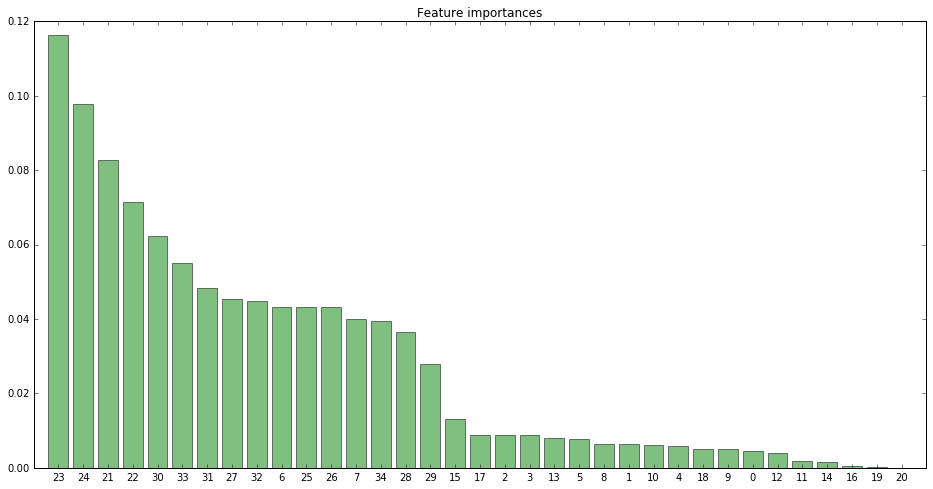

In [60]:
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(train_df.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (16, 8))
plt.title("Feature importances")
plt.bar(range(train_df.shape[1]), importances[indices], color="g", alpha = 0.5, align="center")
plt.xticks(range(train_df.shape[1]), indices)
plt.xlim([-1, train_df.shape[1]])
plt.show()

In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 35 columns):
bathrooms                 49352 non-null float64
bedBathDiff               49352 non-null float64
bedBathSum                49352 non-null float64
bedPerBath                49352 non-null float64
bedrooms                  49352 non-null int64
bedsPerc                  49352 non-null float64
desc_wordcount            49352 non-null int64
display_address           49352 non-null int64
feature_cats              49352 non-null int64
feature_concierge         49352 non-null int64
feature_dogs              49352 non-null int64
feature_furnished         49352 non-null int64
feature_health            49352 non-null int64
feature_laundry           49352 non-null int64
feature_lowfee            49352 non-null int64
feature_nofee             49352 non-null int64
feature_parking           49352 non-null int64
feature_parquet           49352 non-null int64
feature_prewar            49352 no

The first ***six most important features*** are are hcc_manager_id_pred_1, hcc_manager_id_pred_2, hcc_building_id_pred_1,
hcc_building_id_pred_2, price, pricePerRoom.

The ***eight least important features*** are feature_utilities, feature_transport, feature_parking, feature_lowfee, feature_furnished, bathrooms, feature_concierge, feature_prewar.

Let's check the correlation matrix of the first six most important features.

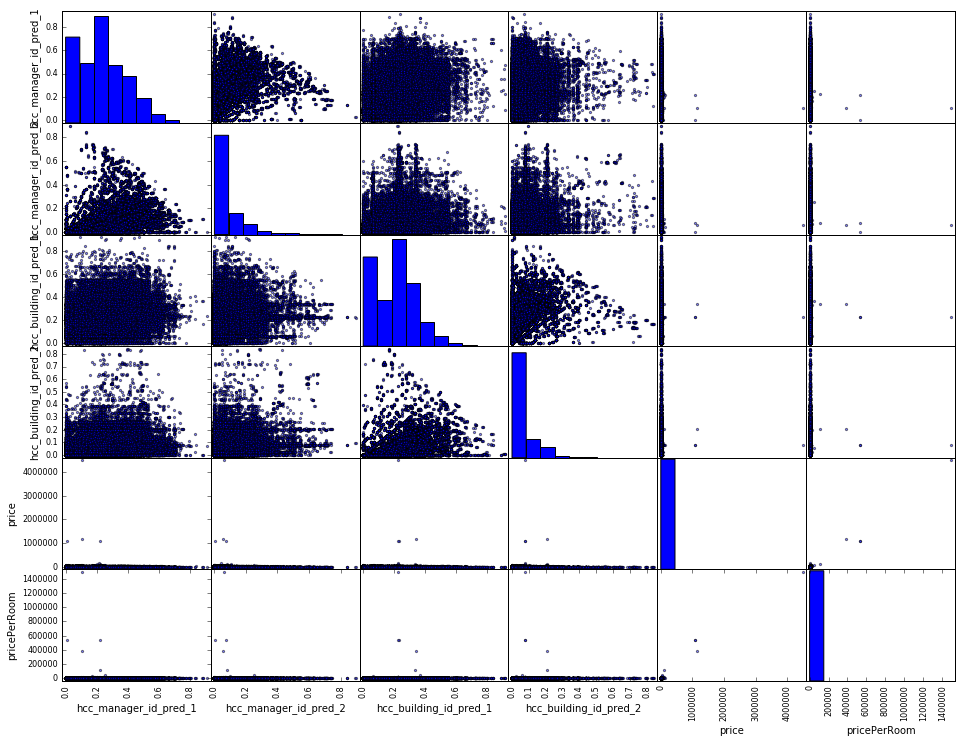

In [70]:
from pandas.tools.plotting import scatter_matrix
df = train_df[['hcc_manager_id_pred_1', 'hcc_manager_id_pred_2', 'hcc_building_id_pred_1', 'hcc_building_id_pred_2', 'price', 'pricePerRoom']]
scatter_matrix(df, figsize = (16, 12))
plt.show()

In [73]:
from scipy.stats import pearsonr
for i in range(5):
    for j in range(i+1, 6):
        x = df.iloc[:,i]
        y = df.iloc[:,j]
        print('i, j, r^2:', i, j, pearsonr(x, y)[0])

i, j, r^2: 0 1 0.448431332643
i, j, r^2: 0 2 0.325348546588
i, j, r^2: 0 3 0.210443882895
i, j, r^2: 0 4 -0.0169863113269
i, j, r^2: 0 5 -0.0206876950632
i, j, r^2: 1 2 0.19417390384
i, j, r^2: 1 3 0.241599152907
i, j, r^2: 1 4 -0.015036783608
i, j, r^2: 1 5 -0.0152830810044
i, j, r^2: 2 3 0.412332430894
i, j, r^2: 2 4 -0.0112778134769
i, j, r^2: 2 5 -0.0128955494139
i, j, r^2: 3 4 -0.0102581285836
i, j, r^2: 3 5 -0.0127964349361
i, j, r^2: 4 5 0.981303199223


***These six features are mostly independent except that price and priceperroom are highly correlated.***

#### 4) Make predictions on the test data

In [63]:
labels2idx = {'high': 2, 'low':0, 'medium':1}

In [64]:
y = clf.predict_proba(test_df)
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]
sub.to_csv("FE6_rf06172018.csv", index=False)

### XGBoost

In [78]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [74]:
train_df = pd.read_json('Datacleaned_FE1_train.json')
test_df = pd.read_json('FE1_test.json')

In [75]:
y = train_df['interest_level'].map({'low':0, 'medium':1,'high': 2})
train_df = train_df.drop(['interest_level'], axis = 1)
x = train_df.values

In [76]:
validation_size = 0.30
seed = 2018
X_train, X_validation, Y_train, Y_validation = train_test_split(x, y, test_size = validation_size, random_state = seed)

In [ ]:
model = XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1]
max_depth = [5, 10, 15]
n_estimators = [10, 20, 50, 100, 150, 200]

param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth)

kfold = StratifiedKFold(Y_train, n_folds = 5, shuffle = True, random_state = 2018)
grid_search = GridSearchCV(model, param_grid, scoring = 'neg_log_loss', n_jobs = -1, cv = kfold)
result = grid_search.fit(X_train, Y_train)

# summarize results
print("BestL %f using %s" % (- result.best_score_, result.best_params_))
means, stdevs = [], []
for params, mean_score, scores in result.grid_scores_:
    stdev = scores.std()
    means.append(- mean_score)
    stdevs.append(stdev)
    print("%f (%f) with: %r" %(- mean_score, stdev, params))    

In [ ]:
model = XGBClassifier(learning_rate = 0.2, n_estimators = 150, max_depth = 5)
model.fit(X_train, Y_train)

In [86]:
importances = model.feature_importances_

Feature ranking:
1. feature 57 (0.086139)
2. feature 54 (0.041942)
3. feature 55 (0.035258)
4. feature 22 (0.031582)
5. feature 26 (0.031414)
6. feature 25 (0.030078)
7. feature 41 (0.028490)
8. feature 28 (0.027905)
9. feature 56 (0.024898)
10. feature 7 (0.022892)
11. feature 16 (0.020637)
12. feature 60 (0.020302)
13. feature 39 (0.020135)
14. feature 52 (0.020135)
15. feature 1 (0.019467)
16. feature 51 (0.019216)
17. feature 36 (0.019216)
18. feature 61 (0.019216)
19. feature 53 (0.018882)
20. feature 49 (0.018882)
21. feature 59 (0.018214)
22. feature 67 (0.018130)
23. feature 38 (0.017963)
24. feature 50 (0.017712)
25. feature 69 (0.017629)
26. feature 40 (0.017545)
27. feature 71 (0.017462)
28. feature 62 (0.017211)
29. feature 19 (0.016877)
30. feature 68 (0.016292)
31. feature 66 (0.016041)
32. feature 63 (0.016041)
33. feature 12 (0.015289)
34. feature 65 (0.015122)
35. feature 43 (0.015039)
36. feature 9 (0.015039)
37. feature 37 (0.014788)
38. feature 33 (0.013201)
39. fea

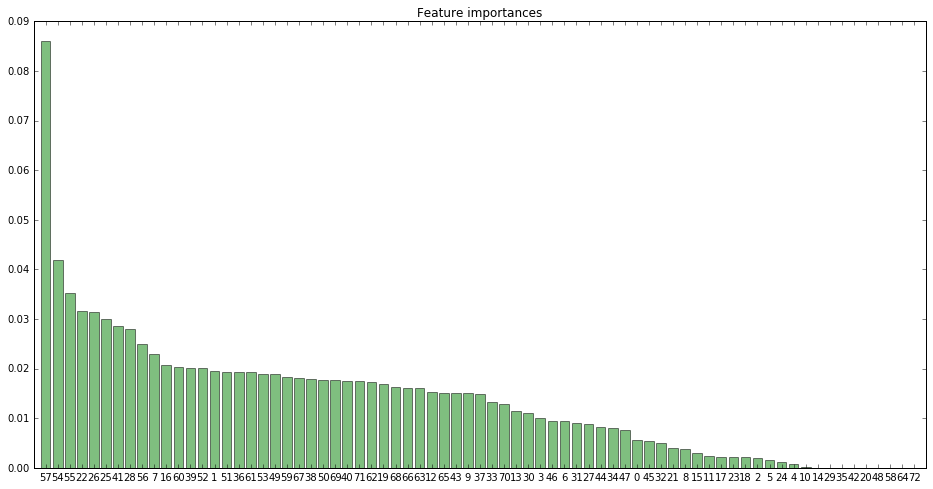

In [87]:
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(train_df.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (16, 8))
plt.title("Feature importances")
plt.bar(range(train_df.shape[1]), importances[indices], color="g", alpha = 0.5, align="center")
plt.xticks(range(train_df.shape[1]), indices)
plt.xlim([-1, train_df.shape[1]])
plt.show()

In [88]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49121 entries, 0 to 9999
Data columns (total 73 columns):
bathrooms                       49121 non-null float64
bathrooms_building_id_count     49121 non-null int64
bathrooms_building_id_max       49121 non-null float64
bathrooms_building_id_mean      49121 non-null float64
bathrooms_building_id_median    49121 non-null float64
bathrooms_building_id_min       49121 non-null float64
bathrooms_building_id_std       49121 non-null float64
bathrooms_manager_id_count      49121 non-null int64
bathrooms_manager_id_max        49121 non-null float64
bathrooms_manager_id_mean       49121 non-null float64
bathrooms_manager_id_median     49121 non-null float64
bathrooms_manager_id_min        49121 non-null float64
bathrooms_manager_id_std        49121 non-null float64
bedrooms                        49121 non-null int64
bedrooms_building_id_count      49121 non-null int64
bedrooms_building_id_max        49121 non-null int64
bedrooms_building_id_m

Top five most important features are price, num_description_words, num_features, bedrooms_manager_id_mean. These difference comes from different feature engineer results. In both XGBoost and RF, price is a key features. This agrees with our statistical analysis that the price of apartments with low interest level and high interest level are statistically significant. By fitting our data using machine learning models, we can conclude the cause-and-effect relationship between price and interest level.

#### Evaluation metrics are:

- i) classification accuracy
- ii) LogLoss
- iii) Confusion matrix
- iv) Classification Report including Prediction, recall, F1 score

i) classification accuracy

In [89]:
y_val_pred = model.predict(X_validation)
accuracy_score(Y_validation, y_val_pred)

0.74587772273868491

ii) LogLoss

In [90]:
y_val_pred_prob = model.predict_proba(X_validation)
log_loss(Y_validation, y_val_pred_prob)

0.56298083973961277

iii) confusion matrix

In [93]:
confusion_matrix(model.predict(X_validation), Y_validation)

array([[9466, 1949,  302],
       [ 749, 1216,  510],
       [  49,  186,  310]])

iv) Classification Report including Prediction, recall, F1 score

In [94]:
print(classification_report(Y_validation, y_val_pred))

             precision    recall  f1-score   support

          0       0.81      0.92      0.86     10264
          1       0.49      0.36      0.42      3351
          2       0.57      0.28      0.37      1122

avg / total       0.72      0.75      0.72     14737



#### Predict the unknown

In [ ]:
#labels2idx = {label: i for i, label in enumerate(clf.classes_)}
y_pred = model.predict_proba(test_df)
for label in ["high", "medium", "low"]:
    sub[label] = y_pred[:, labels2idx[label]]
sub.to_csv("FE1_xgb06152018.csv", index = False)

### LightGBM
Code partially adapted from https://www.kaggle.com/somnisight/microsoft-lightgbm-starter

Microsoft LightGBM is a powerful, open-source boosted decision tree library similar to xgboost. In practice, it runs even faster than xgboost and achieves better performance in some cases.


Let's start with define hyperparameters for LightGBM.

In [ ]:
train_df = pd.read_json("FE6_train.json")
test_df = pd.read_json("FE6_test.json")

In [ ]:
# check y value first, if not numerical, map into low:0, medium:1, high:2
y = train_df['interest_level']
train_df = train_df.drop(['interest_level'], axis = 1)
x = train_df.values

In [ ]:
import lightgbm as lgbm

# parameters are mostly default, need to be tuned
t4_params = {
    'boosting_type': 'gbdt', 'objective': 'multiclass', 'nthread': -1, 'silent': True,
    'num_leaves': 2**4, 'learning_rate': 0.05, 'max_depth': -1,
    'max_bin': 255, 'subsample_for_bin': 50000,
    'subsample': 0.8, 'subsample_freq': 1, 'colsample_bytree': 0.6, 'reg_alpha': 1, 'reg_lambda': 0,
    'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 10, 'scale_pos_weight': 1}


#### Early Stopping with Cross Validation
Similar to xgboost, we can use cross validation with early stopping to efficiently determine the optimal "**n_estimators**" value.

In [ ]:
def cross_validate_lgbm():
    lgbm_params = t4_params.copy()
    lgbm_params['num_class'] = 3
    
    # prepare data for lgbm
    dset = lgbm.Dataset(x, y, silent = True)
    
    # perform cross-validation
    cv_results = lgbm.cv(lgbm_params, dset, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='multi_logloss',
                         early_stopping_rounds=100, verbose_eval=50, show_stdv=True, seed=0)
    
    print('best n_estimators:', len(cv_results['multi_logloss-mean']))
    print('best cv score:', cv_results['multi_logloss-mean'][-1])

In [ ]:
cross_validate_lgbm()

In [ ]:
#model = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=1, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, **kwargs)
model = lgbm.sklearn.LGBMClassifier(n_estimators = 1302, seed = 2018, **t4_params)
model.fit(x, y)

In [ ]:
y_pred = model.predict_proba(test_df.values)

In [ ]:
labels2idx = {'high': 2, 'low':0, 'medium':1}
for label in ["high", "medium", "low"]:
    sub[label] = y_pred[:, labels2idx[label]]
sub.to_csv("FE6_lgbm.csv", index = False)

### Stacking/Averaging
Decrease the prediction logloss slightly.

In [ ]:
a = pd.read_csv("FE6_rf.csv", header = 0)
b = pd.read_csv("FE6_xgb.csv", header = 0)
c = pd.read_csv("FE6_withnan_lgbm.csv", header = 0)
d = pd.read_csv("FE6_lgbm.csv", header = 0)

avg = pd.DataFrame()
avg['listing_id'] = a['listing_id']
avg['high'] = (a['high'] + b['high'] + c['high'] + d['high'])/4.0
avg['medium'] = (a['medium'] + b['medium'] + c['medium'] + d['medium'])/4.0
avg['low'] = (a['low'] + b['low'] + c['low'] + d['low'])/4.0
avg.to_csv('FE6_4avg.csv', index = False)

LB: 0.54455
Best LB score is 0.54073